<a href="https://colab.research.google.com/github/nguyenna162/DAProjectG1/blob/main/PredictiveModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo
!pip install imbalanced-learn

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

# data (as pandas dataframes)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets

# metadata
print(online_shoppers_purchasing_intention_dataset.metadata)

# variable information
print(online_shoppers_purchasing_intention_dataset.variables)




{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'ID': 367, 'type': 'NATIVE', 'title': 'Real-time prediction of online shoppers’ pur

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve


# Tiền xử lý đầu vào
Dùng StandardScale của Z-score normalization



In [4]:
df=pd.DataFrame()

In [5]:
X = pd.get_dummies(X, columns=['Month', 'VisitorType'])

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

month_columns = [col for col in X_scaled.columns if col.startswith('Month_')]
X_scaled['Month_Total'] = X_scaled[month_columns].mean(axis=1)

# Gộp các cột VisitorType_* thành một biến duy nhất
visitor_type_columns = [col for col in X_scaled.columns if col.startswith('VisitorType_')]
X_scaled['VisitorType_Total'] = X_scaled[visitor_type_columns].mean(axis=1)

# Loại bỏ các cột Month và VisitorType riêng lẻ
X_scaled = X_scaled.drop(columns=month_columns + visitor_type_columns)


In [8]:
# Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [9]:
print("Phân phối dữ liệu sau SMOTE:")
print(pd.Series(y_resampled['Revenue']).value_counts())

Phân phối dữ liệu sau SMOTE:
Revenue
False    10422
True     10422
Name: count, dtype: int64


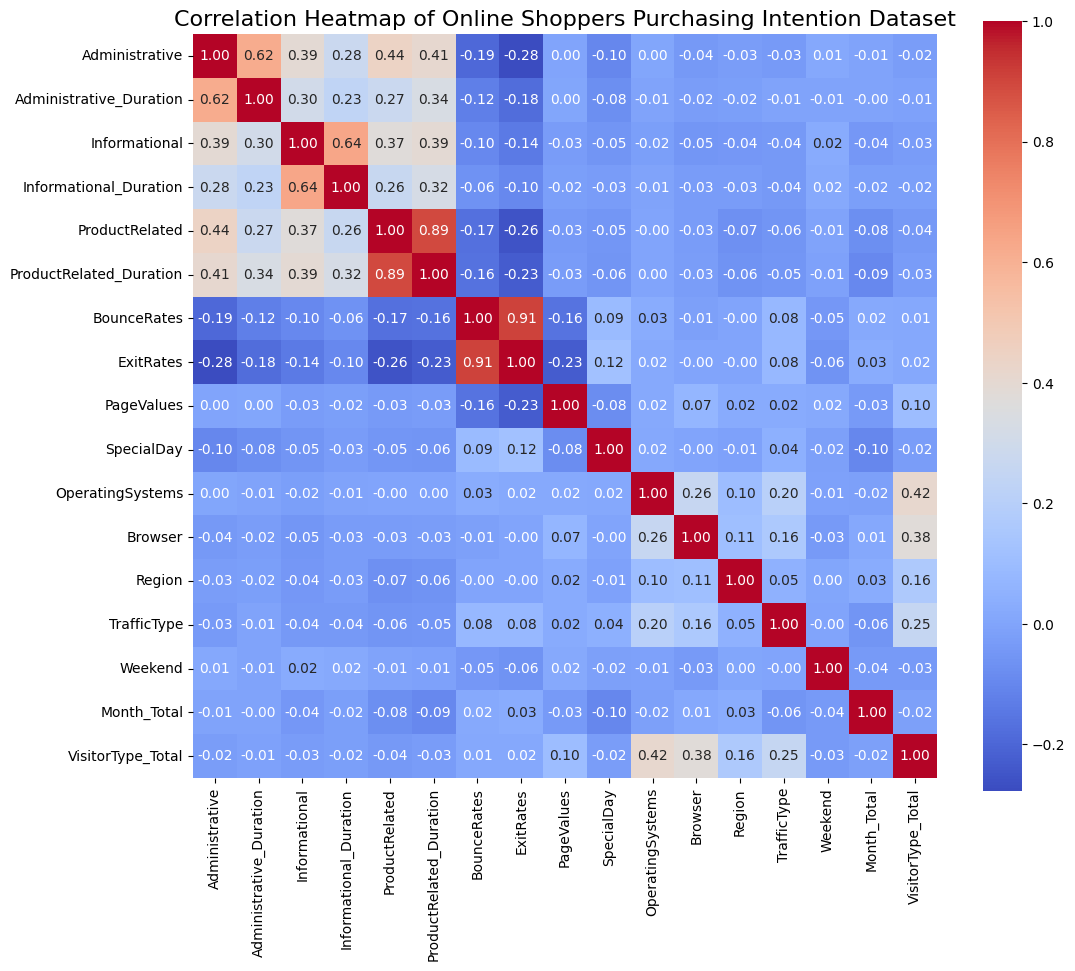

In [10]:
# Tính ma trận tương quan
correlation_matrix = X_resampled.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar=True,
            square=True,
            annot_kws={"size": 10})

plt.title('Correlation Heatmap of Online Shoppers Purchasing Intention Dataset', fontsize=16)

plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled, shuffle=True)

# Compare model by PyCaret
So sánh các model bằng compare model trong Pycaret với dữ liệu đầu vào chưa tiền xử lý, sau đó lựa chọn các model tối ưu nhất để training và lấy f1-score.


In [12]:
!pip install pycaret

In [13]:
from pycaret.classification import setup, compare_models

In [14]:
df = X.copy()
df['Revenue'] = y

In [18]:
model_setup = setup(data=df, target='Revenue', session_id=123,fold=10)

,Description,Value
0,Session id,123
1,Target,Revenue
2,Target type,Binary
3,Original data shape,"(12330, 29)"
4,Transformed data shape,"(12330, 29)"
5,Transformed train set shape,"(8631, 29)"
6,Transformed test set shape,"(3699, 29)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [19]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9033,0.9243,0.5553,0.7554,0.6384,0.5843,0.5944,1.0320
gbc,Gradient Boosting Classifier,0.9027,0.9290,0.6017,0.7239,0.6558,0.5998,0.6041,1.4830
lightgbm,Light Gradient Boosting Machine,0.9027,0.9291,0.6040,0.7243,0.6570,0.6010,0.6053,1.9350
xgboost,Extreme Gradient Boosting,0.8977,0.9204,0.5912,0.7027,0.6409,0.5819,0.5855,0.2560
ada,Ada Boost Classifier,0.8918,0.9143,0.5680,0.6808,0.6185,0.5561,0.5597,0.3760
et,Extra Trees Classifier,0.8906,0.9157,0.4409,0.7504,0.5528,0.4957,0.5197,0.7450
lr,Logistic Regression,0.8845,0.8875,0.3839,0.7477,0.5058,0.4482,0.4809,1.2440
lda,Linear Discriminant Analysis,0.8799,0.8992,0.3367,0.7498,0.4630,0.4065,0.4488,0.0880
svm,SVM - Linear Kernel,0.8764,0.5810,0.3193,0.7857,0.4259,0.3739,0.4353,0.0680
ridge,Ridge Classifier,0.8716,0.8997,0.2387,0.7795,0.3645,0.3150,0.3845,0.0400


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [20]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [21]:
# Training Random Forest
print("\n--- Random Forest ---")
RFclf = RandomForestClassifier(max_depth=10, random_state=0)
RFclf.fit(X_train, y_train)


--- Random Forest ---


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
class_name=np.unique(y_train).astype(str)
class_name

array(['False', 'True'], dtype='<U5')

In [23]:
y_pred=RFclf.predict(X_train)
y_pred

array([ True, False,  True, ...,  True,  True, False])

In [24]:
report = classification_report(y_train,y_pred,target_names=class_name)
print(report)

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      8337
        True       0.93      0.94      0.94      8338

    accuracy                           0.94     16675
   macro avg       0.94      0.94      0.94     16675
weighted avg       0.94      0.94      0.94     16675



In [25]:
class_name=np.unique(y_test).astype(str)
class_name

array(['False', 'True'], dtype='<U5')

In [26]:
y_predict=RFclf.predict(X_test)
y_predict


array([False,  True,  True, ...,  True, False,  True])

In [27]:
report = classification_report(y_test,y_predict,target_names=class_name)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.92      0.92      2085
        True       0.92      0.93      0.92      2084

    accuracy                           0.92      4169
   macro avg       0.92      0.92      0.92      4169
weighted avg       0.92      0.92      0.92      4169



In [28]:
LRclf = LogisticRegression(random_state=0)
LRclf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y_pred=LRclf.predict(X_train)
y_pred

array([ True, False,  True, ...,  True,  True, False])

In [30]:
report = classification_report(y_train,y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.79      0.90      0.84      8337
        True       0.88      0.76      0.82      8338

    accuracy                           0.83     16675
   macro avg       0.84      0.83      0.83     16675
weighted avg       0.84      0.83      0.83     16675



In [31]:
y_predict=LRclf.predict(X_test)
y_predict

array([False,  True,  True, ...,  True, False, False])

In [32]:
report = classification_report(y_test,y_predict)
print(report)

              precision    recall  f1-score   support

       False       0.79      0.90      0.84      2085
        True       0.89      0.76      0.82      2084

    accuracy                           0.83      4169
   macro avg       0.84      0.83      0.83      4169
weighted avg       0.84      0.83      0.83      4169



In [33]:
GBMclf = GradientBoostingClassifier()
GBMclf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [34]:
y_predict=GBMclf.predict(X_train)
y_predict

array([ True, False,  True, ...,  True,  True, False])

In [35]:
report = classification_report(y_train, y_predict)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      8337
        True       0.93      0.93      0.93      8338

    accuracy                           0.93     16675
   macro avg       0.93      0.93      0.93     16675
weighted avg       0.93      0.93      0.93     16675



In [36]:
y_pred=GBMclf.predict(X_test)
y_pred

array([False,  True,  True, ...,  True, False,  True])

In [37]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      2085
        True       0.93      0.93      0.93      2084

    accuracy                           0.93      4169
   macro avg       0.93      0.93      0.93      4169
weighted avg       0.93      0.93      0.93      4169



# Đánh giá mô hình


--- Evaluating Random Forest ---


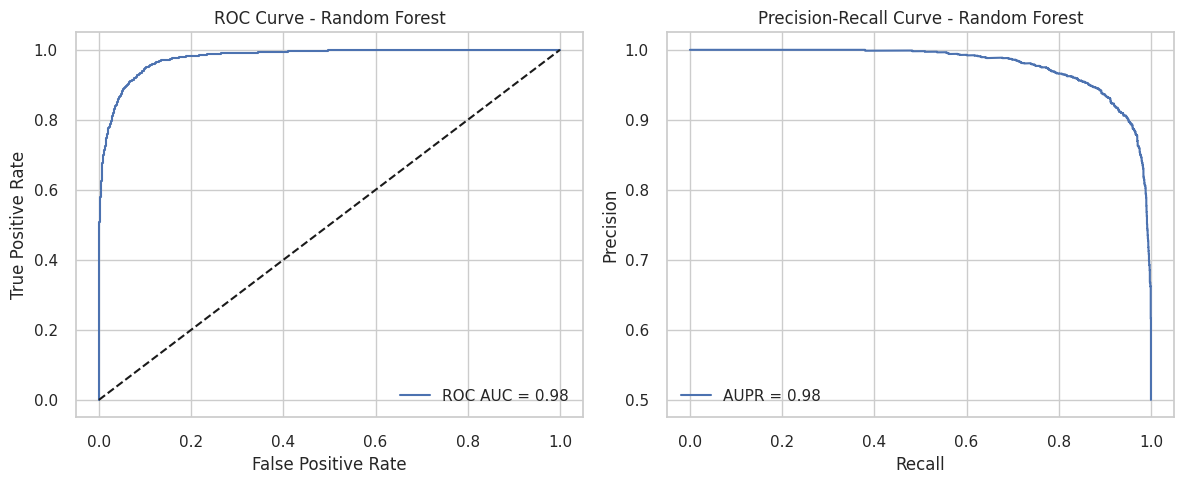

ROC AUC: 0.98
AUPR: 0.98

--- Evaluating Logistic Regression ---


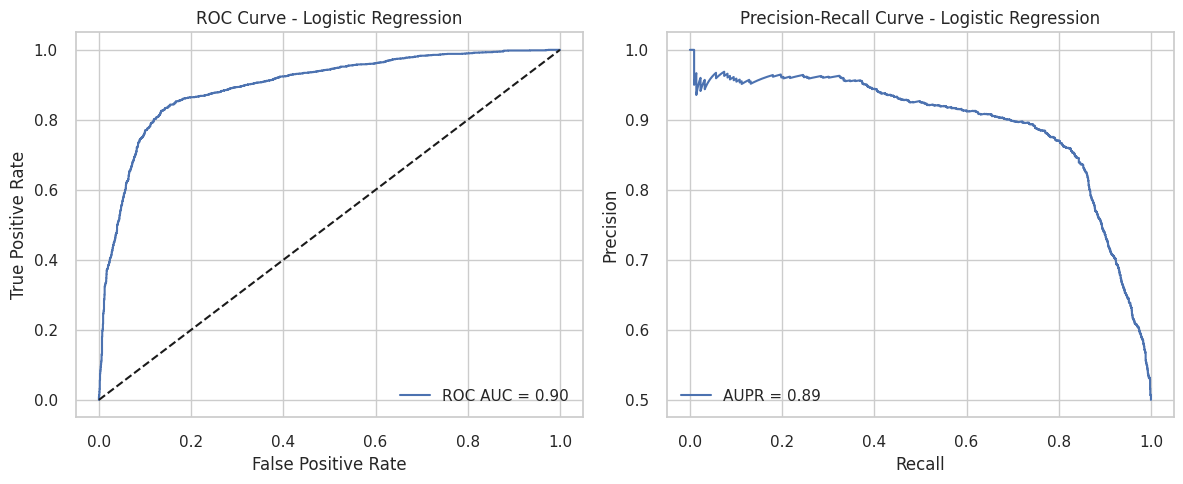

ROC AUC: 0.90
AUPR: 0.89

--- Evaluating Gradient Boosting ---


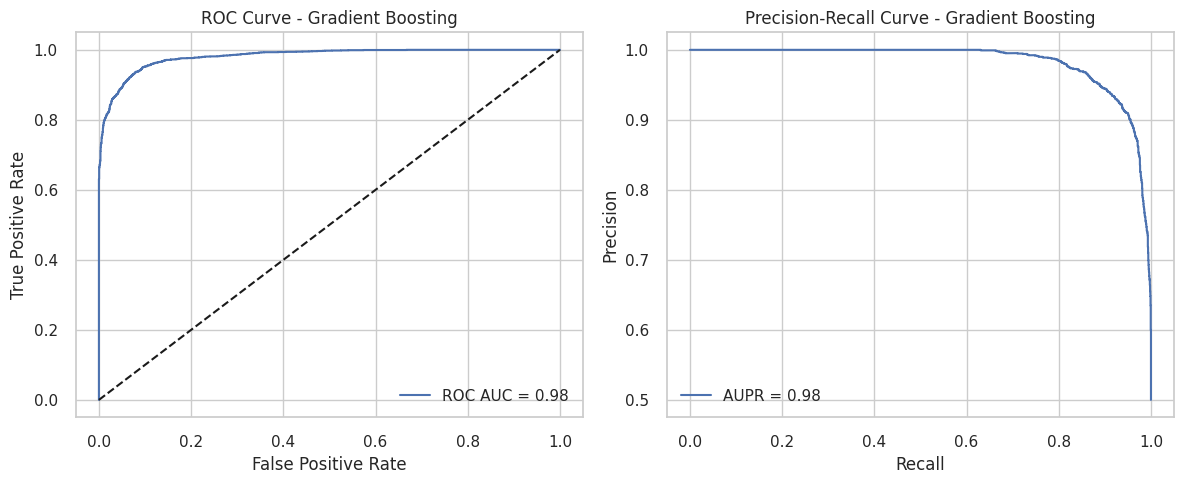

ROC AUC: 0.98
AUPR: 0.98


In [44]:
# Hàm để vẽ ROC Curve và Precision-Recall Curve
def plot_curves(model, X_test, y_test, model_name):
    # Dự đoán xác suất
    y_prob = model.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    aupr = auc(recall, precision)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return roc_auc, aupr

# Đánh giá các mô hình
models = {'Random Forest': RFclf, 'Logistic Regression': LRclf, 'Gradient Boosting': GBMclf}
roc_auc_scores = {}
aupr_scores = {}

for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    roc_auc, aupr = plot_curves(model, X_test, y_test, name)
    roc_auc_scores[name] = roc_auc
    aupr_scores[name] = aupr
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"AUPR: {aupr:.2f}")


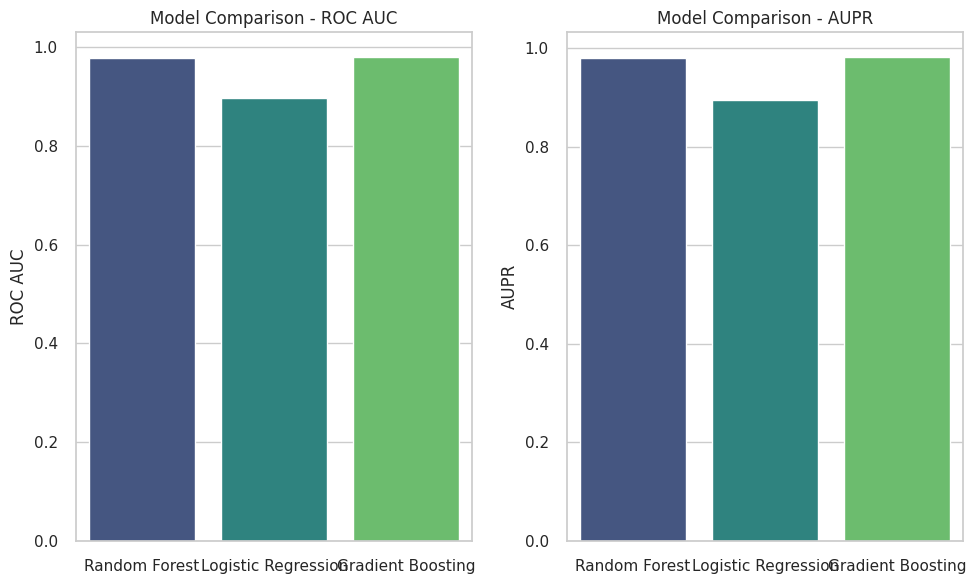

In [45]:
# Vẽ biểu đồ so sánh ROC AUC và AUPR
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), palette='viridis')
plt.title('Model Comparison - ROC AUC')
plt.ylabel('ROC AUC')

plt.subplot(1, 2, 2)
sns.barplot(x=list(aupr_scores.keys()), y=list(aupr_scores.values()), palette='viridis')
plt.title('Model Comparison - AUPR')
plt.ylabel('AUPR')

plt.tight_layout()
plt.show()

In [50]:
from google.colab import files

# Lấy 100 dòng ngẫu nhiên từ tập train
train_indices = np.random.choice(X_train.index, size=100, replace=False)
X_train_demo = X_train.loc[train_indices]
y_train_demo = y_train.loc[train_indices]

# Lấy 100 dòng ngẫu nhiên từ tập test
test_indices = np.random.choice(X_test.index, size=100, replace=False)
X_test_demo = X_test.loc[test_indices]
y_test_demo = y_test.loc[test_indices]

# Kết hợp X và y thành một DataFrame cho tập train
train_demo = pd.concat([X_train_demo, y_train_demo], axis=1)

# Kết hợp X và y thành một DataFrame cho tập test
test_demo = pd.concat([X_test_demo, y_test_demo], axis=1)

# Lưu các tập dữ liệu vào file CSV
train_demo.to_csv('train_demo.csv', index=False)
test_demo.to_csv('test_demo.csv', index=False)



In [52]:
# Tập train lưu riêng, tập test lưu riêng
print("Tải xuống tập train_demo.csv:")
files.download('train_demo.csv')

print("Tải xuống tập test_demo.csv:")
files.download('test_demo.csv')

# Kiểm tra kích thước của các tập demo
print("Kích thước train_demo:", train_demo.shape)
print("Kích thước test_demo:", test_demo.shape)

Tải xuống tập train_demo.csv:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tải xuống tập test_demo.csv:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Kích thước train_demo: (100, 18)
Kích thước test_demo: (100, 18)


In [53]:
# Lấy 1 file gọp của cả demo train demo test
train_demo['Dataset'] = 'Train'
test_demo['Dataset'] = 'Test'

# Kết hợp cả hai tập
combined_demo = pd.concat([train_demo, test_demo], axis=0)

# Lưu vào file CSV
combined_demo.to_csv('combined_demo.csv', index=False)

# Tạo liên kết tải xuống
print("Tải xuống combined_demo.csv:")
files.download('combined_demo.csv')

Tải xuống combined_demo.csv:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Huấn luyện và đánh giá Random Forest trên tập demo
print("\n--- Random Forest trên tập demo ---")
RFclf = RandomForestClassifier(max_depth=10, random_state=0)
RFclf.fit(X_train_demo, y_train_demo['Revenue'])
y_pred_rf = RFclf.predict(X_test_demo)
print("Classification Report for Random Forest (Demo):\n", classification_report(y_test_demo['Revenue'], y_pred_rf))


--- Random Forest trên tập demo ---
Classification Report for Random Forest (Demo):
               precision    recall  f1-score   support

       False       0.88      0.87      0.88        53
        True       0.85      0.87      0.86        47

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

